In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [ ]:
df = pd.read_csv('income.csv')
df

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0
...,...,...,...,...,...,...,...,...,...,...
29995,45,Male,Masters,14,Married,State-gov,Prof-specialty,60,>50K,1
29996,33,Male,HS-grad,9,Married,Private,Machine-op-inspct,40,>50K,1
29997,47,Male,Prof-school,15,Married,Private,Prof-specialty,55,>50K,1
29998,32,Female,Some-college,10,Never-married,Private,Adm-clerical,40,<=50K,0


In [ ]:
df['label'].value_counts() #21700 cases of class 0 (under 50k) and 8300 cases of class 1 (over 50k)

0    21700
1     8300
Name: label, dtype: int64

# **Part 1: Data Preprocessing**
1.1 Separating Categorical Variables

In [ ]:
categorical_col = ['sex', 'education', 'marital-status','workclass', 'occupation'] #categorical columns
continuous_col = ['age','hours-per-week'] #continuous columns
y_col = ['label'] #this will be the answer that we want to be the output of our NN

In [ ]:
df.dtypes #notice the categorical columns are objects, but we want to convert them into categoires

age                int64
sex               object
education         object
education-num      int64
marital-status    object
workclass         object
occupation        object
hours-per-week     int64
income            object
label              int64
dtype: object

In [ ]:
for cat in categorical_col:
  #looping through the categorical_col list so we can convert each column listed into a category datatype
  df[cat] = df[cat].astype('category')

df.dtypes #notice they are categories now

age                  int64
sex               category
education         category
education-num        int64
marital-status    category
workclass         category
occupation        category
hours-per-week       int64
income              object
label                int64
dtype: object

In [ ]:
df['education'].head() #notice the marital status column is has 6 categories

0        HS-grad
1        Masters
2        HS-grad
3    Prof-school
4           11th
Name: education, dtype: category
Categories (14, object): ['10th', '11th', '12th', '5th-6th', ..., 'HS-grad', 'Masters',
                          'Prof-school', 'Some-college']

In [ ]:
print(df['education'].cat.codes.values) #so we're given a code for each education level
print(df['sex'].cat.codes.values) #so we're given a code for male = 0, female = 1

[10 11 10 ... 12 13  6]
[1 1 1 ... 1 0 1]


In [ ]:
cats = np.stack([df[col].cat.codes.values for col in categorical_col], axis = 1) #so we're stacking the arrays together along the y-axis to make a row for each
cats = torch.tensor(cats, dtype = torch.int64) #converting our categories into a PyTorch Tensor to feed into our model

cats #first row is male, HS-grad, Never-Married, Private, Craft-repair with their respective encoded values

tensor([[ 1, 10,  3,  2,  1],
        [ 1, 11,  1,  1,  2],
        [ 1, 10,  0,  3,  7],
        ...,
        [ 1, 12,  1,  2,  7],
        [ 0, 13,  3,  2,  0],
        [ 1,  6,  1,  3,  2]])

1.2 Separating Continuous Variables

In [ ]:
conts = np.stack([df[col].values for col in continuous_col], axis = 1) #doing what we did above to categorical value
conts = torch.tensor(conts, dtype=torch.float) #converting our continous variables into a PyTorch Tensor feed into our model

conts #first row is age 27 and 40 hours worked

tensor([[27., 40.],
        [47., 50.],
        [59., 20.],
        ...,
        [47., 55.],
        [32., 40.],
        [33., 60.]])

1.3 Separating Label

In [ ]:
y = torch.tensor(df[y_col].values).flatten() 
y

tensor([0, 1, 0,  ..., 1, 0, 1])

In [ ]:
print('cats.shape =',cats.shape)
print('conts.shape =',conts.shape)
print('y.shape =',y.shape)
#shapes are as expected with 5 columns in categorical, 2 columns in continuous, and 1 column as the label

cats.shape = torch.Size([30000, 5])
conts.shape = torch.Size([30000, 2])
y.shape = torch.Size([30000])


1.4 Embedding our Categories (One Hot Encoding)

In [ ]:
categorical_sizes = [len(df[col].cat.categories) for col in categorical_col] #category sizes
categorical_sizes #so sex has 2 classes, education has 14, marital has6, work class has 5, and occupation has 12

[2, 14, 6, 5, 12]

In [ ]:
emb_sizes = [(size, min(50, (size+1)//2)) for size in categorical_sizes] #so for size [2, 14, 6, 5, 12] in categorical_sizes, embed 50 or take the size and divide by 2
#the +1 is incase we only have 2 categories and // is to make sure the output is an integer
emb_sizes #none of the sizes exceeded 50, so it just made the embedding size the size divided by 2. 
#so here, our number of categories are [2, 14, 6, 5, 12] and our embedding sizes are 1,7,3,3,6

#So the embedding provides a more compact (lower dimensional) representation of a set of input variables that have some correlations. It's useful because it reduces the number of parameters overall. 
#So technically we could've just used all 2+14+6+5+12 as inputs into our NN, but we used embedding to reduce the parameters and make calculations faster
#An embedding layer simply maps/projects some N dimensional tensor into another number of dimensions, the number of dimensions to output to are often arbitrary, but you can have some logic to it, like embedding marital status to 2 dimensions may end up mapping closely to single vs not single or workclass to 2 dimensions could give government vs private (although there is no guarantee of this)

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

# **Part 2: Creating the Model**


In [ ]:
#Inheriting from nn.Module to use it's features
class Model(nn.Module):
  
  def __init__(self, emb_sizes, n_continuous, out_size, n_layers, p=0.5):
    #so our parameters are embedding size, number of continous features, output size, number of layers, and our dropout probability defaulted to 50%
    #This determins how many layers are there in our NN

    super().__init__() #inheriting the features from nn.Module
    self.embeds = nn.ModuleList([nn.Embedding(num_embeddings = ni, embedding_dim = nf) for ni,nf in emb_sizes]) #so now our ModuleList is filled with the Embedding layers (one for hour, one of ampm, and one for weekday)
    self.emb_drop = nn.Dropout(p) #adding a dropout layer
    self.bn_cont = nn.BatchNorm1d(n_continuous) #normalizing the continous data so it falls within the same order of magnitude range

    layerlist = [] #initializing layerlist so we can store our layers
    n_emb = sum([nf for ni,nf in emb_sizes]) #calculating the number of embeddings, which is basically 12 + 1 + 4
    n_in = n_emb + n_continuous #so the total number of inputs will be the number of embeddings plus the number of continous features

    for i in n_layers:
      layerlist.append(nn.Linear(n_in, i)) #create a layer connecting n_in and i, where i is the number of neurons. Basically this makes a fully connected layer. 
      layerlist.append(nn.ReLU(inplace = True)) #adding the activation function to the layer
      layerlist.append(nn.BatchNorm1d(i)) #adding the normalization of the continuous values to the list
      layerlist.append(nn.Dropout(p)) #adding the dropout to the layer
      n_in = i #equating n_in with the number of neurons i, so that the next fully connected layer can start with i - 1 neurons.

    #So layers is going to look like this: layers = [192, 96, 48] meaning you want 256 neurons in first layer, then 128 neurons in second layer, then 64. This allows us play around with the values and makes it flexible. 
    layerlist.append(nn.Linear(n_layers[-1], out_size)) #so making the last layer be connected by the last layer and output size
    self.layers = nn.Sequential(*layerlist) #using sequential to combine the layers from the layerlist so that it can be ordered properly as a NN

  def forward(self, x_categorical, x_continuous):
    #So this determines the forward propagation with the activation functions we want to use

    # Now we are utilizing the embeddings to pass into our forward method
    embeddings = [] 

    for i,e in enumerate(self.embeds):
      embeddings.append(e(x_categorical[:,i])) #so we're adding to our embeddingz list for each row and column i in our categorical inputs, x_cat

    x = torch.cat(tensors = embeddings, dim = 1) #so we're concatenating embeddings along dimension 1, meaning all the values we got above for each tensor will be within a single row (i.e. 12(hour) + 1(amorpm) + 4(weekday) all in one row within a single tensor)
    x = self.emb_drop(x) #adding the drop out layer to our embedded categorical data

    x_cont = self.bn_cont(x_continuous) #normalizing our continuous data
    x = torch.cat(tensors = [x, x_continuous], dim = 1) #concatenating our categorical and continuous data to be in a single tensor row
    x = self.layers(x) #passing our continuous and categorical data into our NN, which was made above with Sequential

    return x

In [ ]:
model = Model(emb_sizes,  n_continuous = conts.shape[1], out_size = 2, n_layers = [192, 96, 48]) #conts.shape[1] is the number of columns in the continuous tensor, output size is 2 (since we have 2 classes, 0 or 1, which is a binary classification problem), and hidden layers will have 192 then 96 then 48 neurons
model

Model(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=192, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=192, out_features=96, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=96, out_features=48, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_featu

In [ ]:
criterion = nn.CrossEntropyLoss() #so our loss measurement will be based off CrossEntropyLoss since this is a mutually exclusive answer (only 1 target can be correct)

optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001) #model parameters are just the fully connected layers and we are using Adam optimizer to optimize them
model.parameters #can see the parameters are just the fully connected layers and we are optimizing them

<bound method Module.parameters of Model(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=192, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=192, out_features=96, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=96, out_features=48, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inpla

In [ ]:
batch_size = 30000 #just going to feed in all the data
test_size = int(batch_size*0.20) #making our test size 1/3 the batch size

#Our data was shuffled already when we got it, which is why we can do the following. If it wasn't shuffled already, then we'd need to shuffle first before assigning the train test split

categorical_train = cats[:batch_size - test_size] #so take from index 0 to 24000
categorical_test = cats[batch_size - test_size: batch_size] #take from index 24000 to 30000
continuous_train = conts[:batch_size - test_size]
continuous_test = conts[batch_size - test_size: batch_size]
y_train = y[:batch_size - test_size]
y_test = y[batch_size - test_size: batch_size]

print(len(categorical_train))
print(len(categorical_test))
print(len(continuous_train))
print(len(continuous_test))
print(len(y_train))
print(len(y_test))

24000
6000
24000
6000
24000
6000


In [ ]:
import time #Gonna try to keep track of how long it takes to train our model

start_time = time.time()

epochs = 500

losses = []

#This for loop trains our NN
for i in range(epochs):
  #Forward propagation through our ANN using training data
  y_pred = model.forward(categorical_train, continuous_train)

  #Calculating loss/error
  loss = criterion(y_pred, y_train)
  losses.append(loss)
  if i%50 == 1:
    print(f'epoch {i} and loss is: {loss} and time: {(time.time() - start_time)/60}')

  #Backpropagation
  optimizer.zero_grad() #resetting the gradient on the optimizer so it doesn't accumulate
  loss.backward() #doing backpropagation off the loss function
  optimizer.step() #using the optimizer for the back propagation

print(f'Training took {(time.time() - start_time)/60} minutes')

epoch 1 and loss is: 0.7249107956886292 and time: 0.01924690802892049
epoch 51 and loss is: 0.49307575821876526 and time: 0.709987465540568
epoch 101 and loss is: 0.43053433299064636 and time: 1.3998127261797586
epoch 151 and loss is: 0.3932628035545349 and time: 2.1041576266288757
epoch 201 and loss is: 0.3546769618988037 and time: 2.797495452562968
epoch 251 and loss is: 0.3357846140861511 and time: 3.48924898703893
epoch 301 and loss is: 0.3224593698978424 and time: 4.1829642454783125
epoch 351 and loss is: 0.3142148554325104 and time: 4.868505966663361
epoch 401 and loss is: 0.3092731237411499 and time: 5.556210096677145
epoch 451 and loss is: 0.3064259886741638 and time: 6.25267273982366
Training took 6.947432510058085 minutes


# **Part 3: Evaluating and Testing the Model**

Text(0.5, 0, 'Epoch')

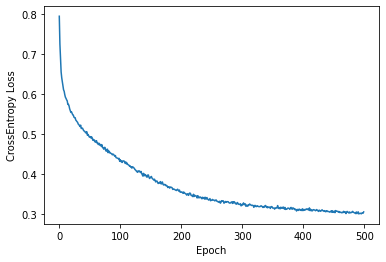

In [ ]:
#Plotting our error
plt.plot(range(epochs),losses)
plt.ylabel('CrossEntropy Loss')
plt.xlabel('Epoch') 

In [ ]:
#This just turns off the backpropagation, so we can use the model for evaluation rather than training. This helps reduce memory usage and computation speed
with torch.no_grad():
  y_val = model.forward(categorical_test, continuous_test)
  loss = criterion(y_val, y_test) #comparing the actual results with the evaluation results

print('Cross Entropy loss =',loss) #average cross entropy loss

Cross Entropy loss = tensor(0.3108)


In [ ]:
rows = 6000
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST

5145 out of 6000 = 85.75% correct
